In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from scipy.signal import savgol_filter

In [3]:
def read_file_list(file_list):
    o = []
    for f in file_list:
        objects = []
        with (open(f, "rb")) as openfile:
            while True:
                try:
                    objects.append(pickle.load(openfile))
                except EOFError:
                    break
        o.append(objects)
    return o

In [4]:
def plot_eval(folder_list, label_list):
    assert(len(folder_list) == len(label_list))
    
    a_list = []
    
    for f in folder_list:
        dirs_containing_res = os.listdir(f)
        eval_file_list = []
        
        try:
            for d in dirs_containing_res:
                eval_file_list.append(f + d + "/eval.pkl")
            e = read_file_list(eval_file_list)
            e = np.array(e)
            e = e.reshape(e.shape[0], e.shape[-1])
            
        except:
            eval_file_list = []
            
            for d in dirs_containing_res:
                eval_file_list.append(f + d + "/eval")

            e = read_file_list(eval_file_list)
            e = np.array(e)
            e = e.reshape(e.shape[0], e.shape[-1])
        
        
        a_list.append(e)
    
    for i, label in enumerate(label_list):
        x = np.arange(len(np.mean(a_list[i], 0)))
        
        m = np.mean(a_list[i], 0)
        std = np.std(a_list[i], 0)
        
        plt.plot(x, m, label=label)
        plt.fill_between(x, m - std, m + std, alpha=0.2)
    plt.legend()
    plt.show()
    
    return a_list


In [5]:
def plot_test_seq(folder_list, seq_idx, has_mode_list, label_list, seqname):
    mode_label_list = ['StdGP', 'NoStdGP', 'TruePrior']
    a_list = []
    
    for f in folder_list:
        dirs_containing_res = os.listdir(f)
        test_file_list = []
        
        try:
            for d in dirs_containing_res:
                test_file_list.append(f + d + "/test")
            e = read_file_list(test_file_list)
            e = np.array(e)
            e = e.squeeze(1)
        except:
            test_file_list = []
            
            for d in dirs_containing_res:
                test_file_list.append(f + d + "/test.pkl")

            e = read_file_list(test_file_list)
            e = np.array(e)
            e = e.squeeze(1)
            
        a_list.append(e)
    
    for i, a in enumerate(a_list):
        if has_mode_list[i]:
            for mode in range(3):
                v = a[:, :, mode, seq_idx]
                v = v.tolist()
                v = np.array(v)
                m = np.mean(v, (0,2))
                std = np.std(v, (0,2))
                x = np.arange(len(m))
                plt.plot(x, m, label=label_list[i] + " " + mode_label_list[mode])
                plt.fill_between(x, m - std, m + std, alpha=0.2)
        else:
            v = a[:, :, seq_idx]
            v = v.tolist()
            v = np.array(v)
            
            m = np.mean(v, (0, 2))
            std = np.std(v, (0, 2))
            
            x = np.arange(len(m))
            plt.plot(x, m, label=label_list[i])
            plt.fill_between(x, m - std, m + std, alpha=0.2)
            
    plt.title("Sequence {}".format(seqname))
    plt.legend(title='title', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [6]:
def view_tracking(f, prior_sequences, show_std=True):
    dirs_containing_res = os.listdir(f)
    eval_file_list = []
    for d in dirs_containing_res:
        eval_file_list.append(f + d + "/final_test.pkl")
    e = read_file_list(eval_file_list)
    e = np.array(e)
    
    num_seq = e.shape[-1]
    
    for seq_idx in range(num_seq):
        x = np.arange(len(e[0, 0, 0, seq_idx]))
        
        # Plot evaluation results 
        eval_true_sigma_list = np.array([e[p, 0, 0, seq_idx] for p in range(e.shape[0])])
        m = np.mean(eval_true_sigma_list, 0)
        std = np.std(eval_true_sigma_list, 0)
        plt.plot(x, m, label="True sigma")
        plt.fill_between(x, m - std, m + std, alpha=0.2)

        eval_false_sigma_list = np.array([e[p, 0, 1, seq_idx] for p in range(e.shape[0])])
        m = np.mean(eval_false_sigma_list, 0)
        std = np.std(eval_false_sigma_list, 0)
        plt.plot(x, m, label="False sigma")
        plt.fill_between(x, m - std, m + std, alpha=0.2)

        eval_prior = np.array([e[p, 0, 2, seq_idx] for p in range(e.shape[0])])
        m = np.mean(eval_prior, 0)
        std = np.std(eval_prior, 0)
        plt.plot(x, m, label="True prior")
        plt.fill_between(x, m - std, m + std, alpha=0.2)
        
        plt.title("Evaluation sequence idx = {}".format(seq_idx))
        plt.legend(title='Algorithm', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.plot()
        plt.show()
        
        # plot sequence tracking
        prediction_mean_true_sigma_list = np.array([e[p, 0, 4, seq_idx] for p in range(e.shape[0])])
        m = np.mean(prediction_mean_true_sigma_list, 0)
        std = np.mean(prediction_mean_true_sigma_list, 0)
        plt.plot(x, m, label="GP Pred True sigma")
        plt.fill_between(x, m - std, m + std, alpha=0.2)
        
        history_true_sigma = np.array([e[p, 0, 3, seq_idx][:, 0, 0].tolist() for p in range(e.shape[0])])
        m = np.mean(history_true_sigma, 0)
        std = np.mean(history_true_sigma, 0)
        plt.plot(x, m, label="Posterior True")
        plt.fill_between(x, m - std, m + std, alpha=0.2)

        prediction_mean_false_sigma_list = np.array([e[p, 0, 6, seq_idx] for p in range(e.shape[0])])
        m = np.mean(prediction_mean_false_sigma_list, 0)
        std = np.mean(prediction_mean_false_sigma_list, 0)
        plt.plot(x, m, label="GP Pred False sigma")
        plt.fill_between(x, m - std, m + std, alpha=0.2)

        history_false_sigma = np.array([e[p, 0, 5, seq_idx][:, 0, 0].tolist() for p in range(e.shape[0])])
        m = np.mean(history_false_sigma, 0)
        std = np.mean(history_false_sigma, 0)
        plt.plot(x, m, label="Posterior False")
        plt.fill_between(x, m - std, m + std, alpha=0.2)

        num_t = len(prior_sequences[seq_idx])
        true_task = [prior_sequences[seq_idx][i][0].item() for i in range(num_t)]
        plt.plot(x, true_task, label="True task")

        plt.title("Latent space tracking of sequence idx = {}".format(seq_idx))
        plt.legend(title='Algorithm', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

In [7]:
def plot_eval_offset(folder_list, label_list, offset_list, need_fix_list):
    assert(len(folder_list) == len(label_list))
    
    a_list = []
    
    for f in folder_list:
        dirs_containing_res = os.listdir(f)
        eval_file_list = []
        
        try:
            for d in dirs_containing_res:
                eval_file_list.append(f + d + "/eval.pkl")
            e = read_file_list(eval_file_list)
            e = np.array(e)
            e = e.reshape(e.shape[0], e.shape[-1])
            
        except:
            eval_file_list = []
            
            for d in dirs_containing_res:
                eval_file_list.append(f + d + "/eval")

            e = read_file_list(eval_file_list)
            e = np.array(e)
            e = e.reshape(e.shape[0], e.shape[-1])
        
        
        a_list.append(e)
        
    for i, fix in enumerate(need_fix_list):
        temp = []
        if fix:
            min_len = 199
            for p in range(len(a_list[i])):
                if len(a_list[i][p][0]) > min_len:
                    t = []
                    for j, elem in enumerate(a_list[i][p][0]):
                        if j % 4 == 0 and len(t) < min_len:
                            t.append(elem)
                    a_list[i][p] = [t]
                else:
                    t = a_list[i][p]
                    a_list[i][p] = t
            a_list[i] = np.array([a_list[i][p][0] for p in range(len(a_list[i]))])
                
    for i, label in enumerate(label_list):
        m = np.mean(a_list[i], 0)
        std = np.std(a_list[i], 0)
        
        if offset_list[i] is not None:
            x = np.arange(len(np.mean(a_list[i], 0)) + offset_list[i])
            offset_m = np.ones(offset_list[i]) * m[0]
            offset_std = np.ones(offset_list[i]) * std[0]
            m = np.concatenate([offset_m, m])
            std = np.concatenate([offset_std, std])
        
        plt.plot(x, m, label=label)
        plt.fill_between(x, m - std, m + std, alpha=0.2)
    plt.legend()
    plt.show()
    
    return a_list


# GAUSS-V0

In [149]:

def get_const_task_sequence(alpha, n_restarts, num_test_processes, std):
    kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))

    gp_list = []
    for i in range(num_test_processes):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=True,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    init_prior_test = [torch.tensor([[-10], [5]], dtype=torch.float32) for _ in range(num_test_processes)]

    mean = -5

    prior_seq = []
    for idx in range(15):
        prior_seq.append(torch.tensor([[mean], [std]], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test


def get_linear_task_sequence(alpha, n_restarts, num_test_processes, std):
    kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))

    gp_list = []
    for i in range(num_test_processes):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=True,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    init_prior_test = [torch.tensor([[30], [5]], dtype=torch.float32) for _ in range(num_test_processes)]

    prior_seq = []
    for idx in range(20):
        mean = 30 - idx

        prior_seq.append(torch.tensor([[mean], [std]], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test


def get_phase_task_sequence(alpha, n_restarts, num_test_processes, std):
    kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))

    gp_list = []
    for i in range(num_test_processes):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=True,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    init_prior_test = [torch.tensor([[-5], [5]], dtype=torch.float32) for _ in range(num_test_processes)]

    prior_seq = []
    for idx in range(40):
        if idx < 15:
            mean = 0
        elif idx < 30:
            mean = 10
        else:
            mean = 0

        prior_seq.append(torch.tensor([[mean], [std]], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test


def get_abrupt_and_smooth(alpha, n_restarts, num_test_processes, std):
    kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))

    gp_list = []
    for i in range(num_test_processes):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=True,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    init_prior_test = [torch.tensor([[-30], [5]], dtype=torch.float32) for _ in range(num_test_processes)]
    prior_seq = []

    for idx in range(60):
        if idx < 15:
            mean = -30
        elif idx < 50:
            mean = -20 + (idx - 15)
        else:
            mean = -20 + 50 - 15

        prior_seq.append(torch.tensor([[mean], [std]], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test

def get_sequences_gauss_v0(alpha, n_restarts, num_test_processes, std):
    # Retrieve task
    gp_list_const, prior_seq_const, init_prior_const = get_const_task_sequence(alpha, n_restarts,
                                                                               num_test_processes, std)
    gp_list_linear, prior_seq_linear, init_prior_linear = get_const_task_sequence(alpha, n_restarts,
                                                                                  num_test_processes,
                                                                                  std)
    gp_list_phase, prior_seq_phase, init_prior_phase = get_phase_task_sequence(alpha, n_restarts, num_test_processes,
                                                                               std)
    gp_list_both, prior_seq_both, init_prior_both = get_abrupt_and_smooth(alpha, n_restarts, num_test_processes, std)

    # Fill lists
    prior_sequences = [prior_seq_const, prior_seq_linear, prior_seq_phase, prior_seq_both]
    gp_list_sequences = [gp_list_const, gp_list_linear, gp_list_phase, gp_list_both]
    init_prior = [init_prior_const, init_prior_linear, init_prior_phase, init_prior_both]

    return prior_sequences, gp_list_sequences, init_prior

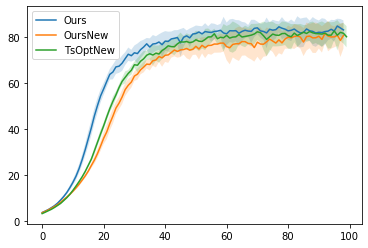

In [154]:
files = ["../result/gauss_final/ours/",
        "../result/gauss_final/oursnew/",
        "../result/gauss_final/tsoptnew/"]

labels = ['Ours', 'OursNew', 'TsOptNew']

r = plot_eval(files, labels)

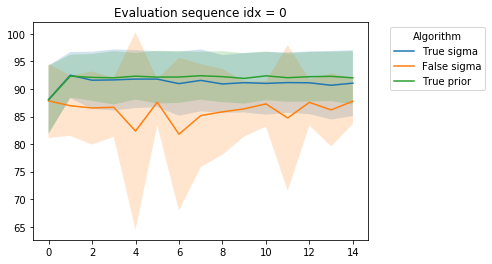

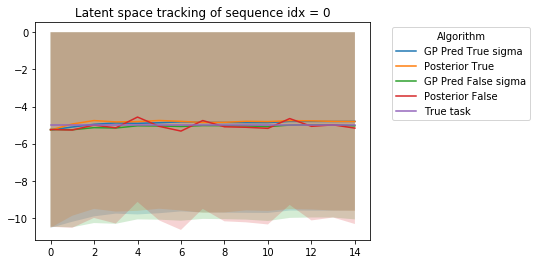

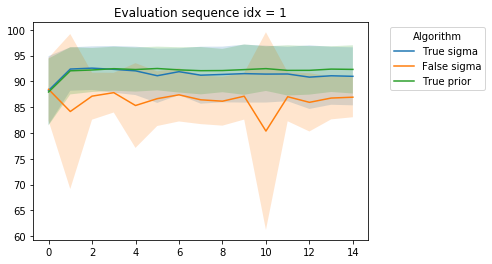

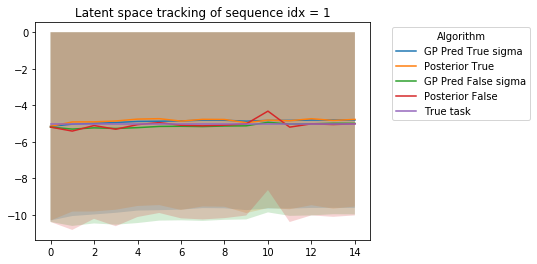

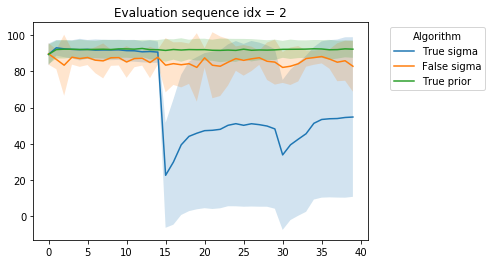

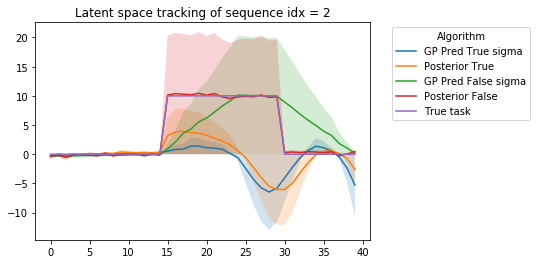

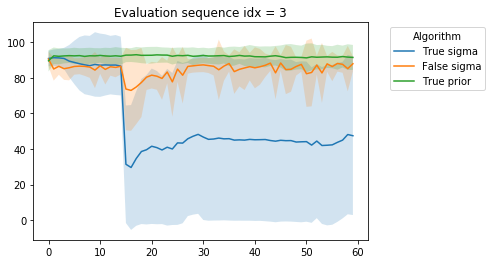

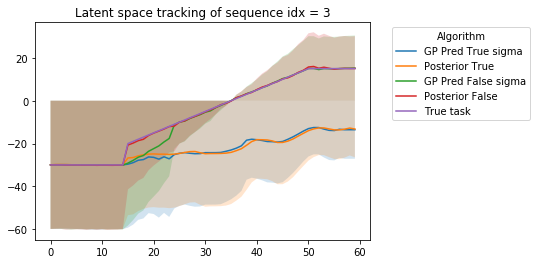

In [153]:
prior_sequences, _ ,_ = get_sequences_gauss_v0(0.2, 1, 1, 0.001)
view_tracking("../result/gauss_final/ours/", prior_sequences)

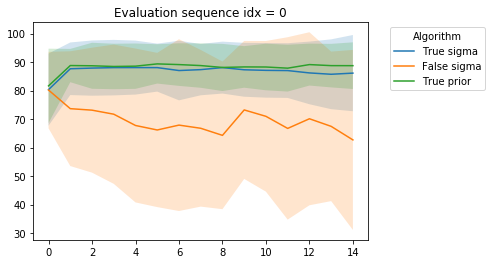

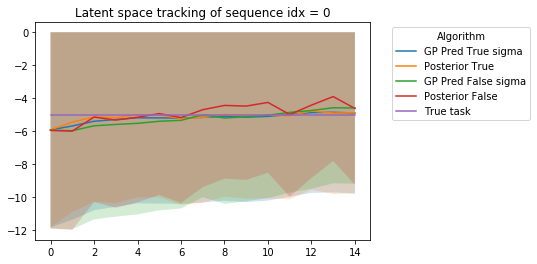

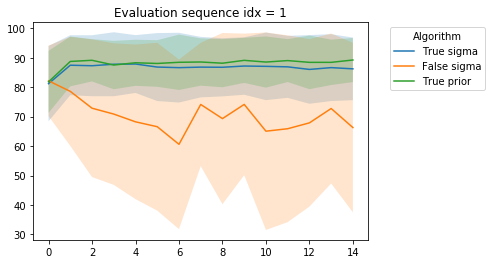

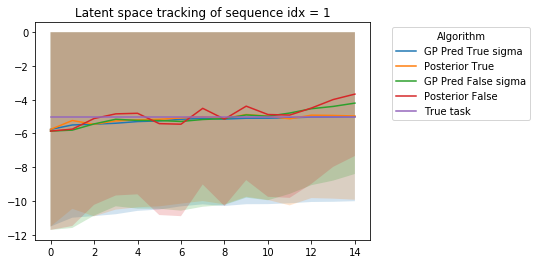

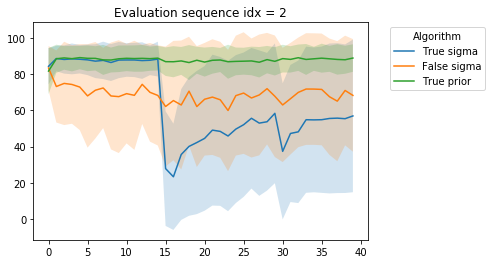

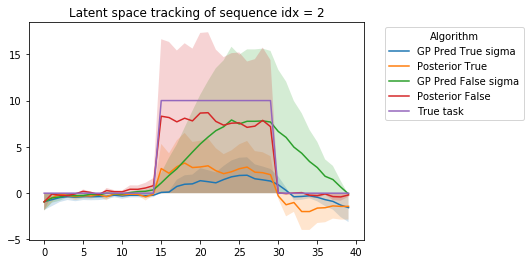

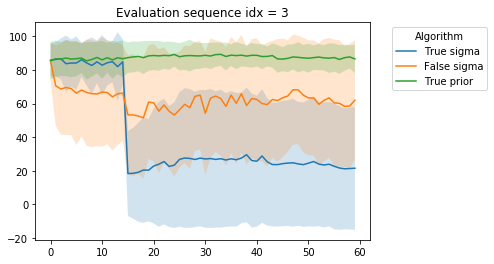

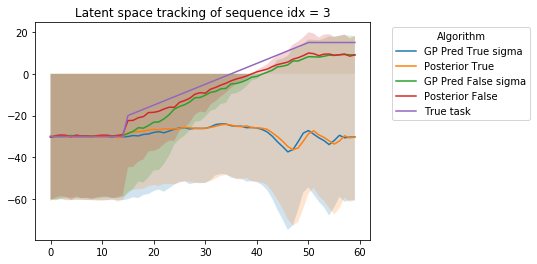

In [151]:
prior_sequences, _ ,_ = get_sequences_gauss_v0(0.2, 1, 1, 0.001)
view_tracking("../result/gauss_final/oursnew/", prior_sequences)

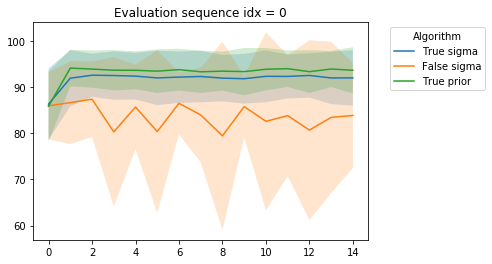

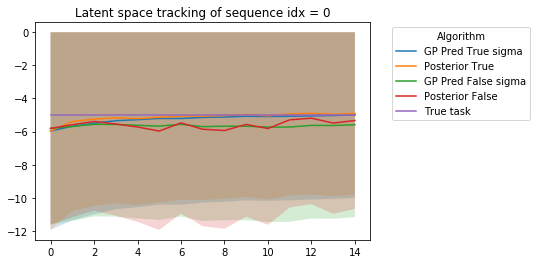

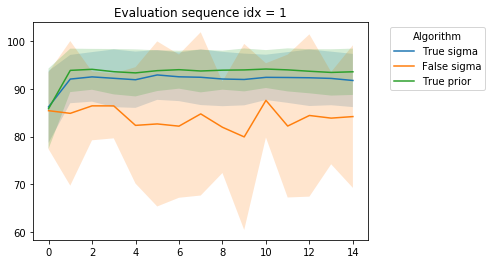

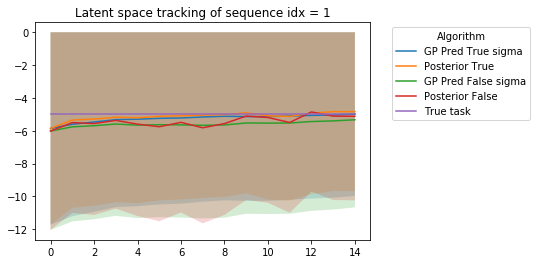

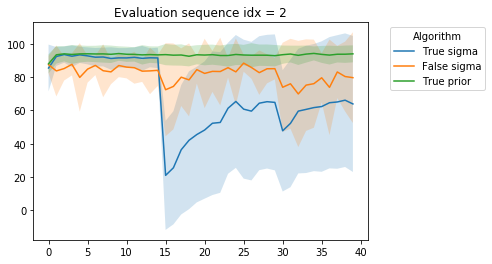

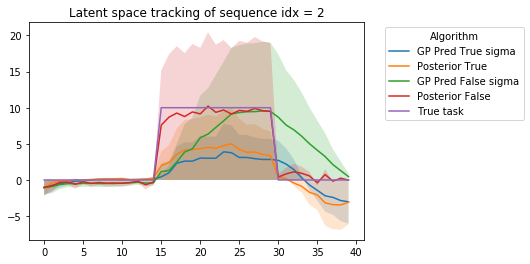

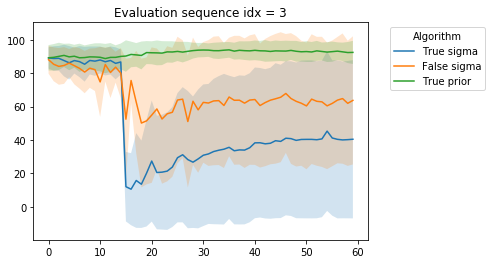

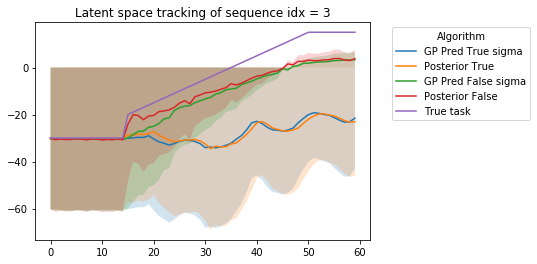

In [155]:
prior_sequences, _ ,_ = get_sequences_gauss_v0(0.2, 1, 1, 0.001)
view_tracking("../result/gauss_final/tsoptnew/", prior_sequences)

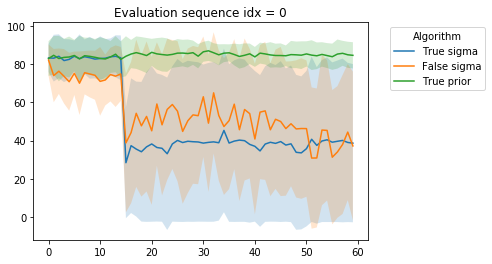

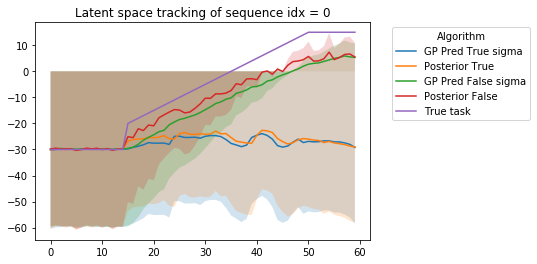

In [186]:
prior_sequences, _ ,_ = get_sequences_gauss_v0(0.2, 1, 1, 0.001)
prior_sequences = [prior_sequences[-1]]
view_tracking("../result/gauss_final/oursnew2/", prior_sequences)

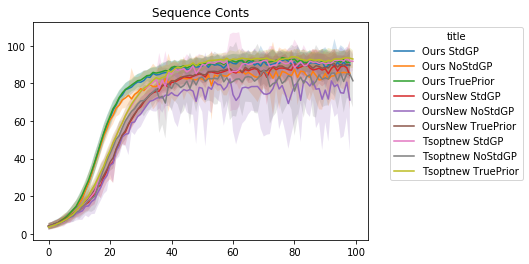

In [159]:
files = ["../result/gauss_final/ours/",
        "../result/gauss_final/oursnew/",
        "../result/gauss_final/tsoptnew/"]

labels = ['Ours', 'OursNew','Tsoptnew']

plot_test_seq(files, 
              seq_idx=0, 
              has_mode_list=[True, True,True], 
              label_list=labels,
              seqname='Conts')

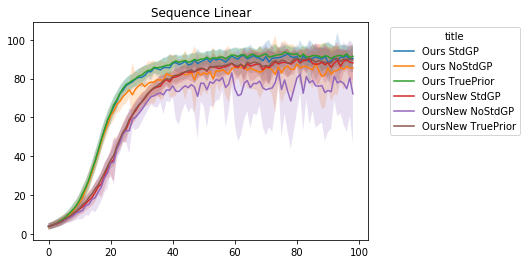

In [144]:
files = ["../result/gauss_final/ours/",
        "../result/gauss_final/oursnew/"]

labels = ['Ours', 'OursNew']

plot_test_seq(files, 
              seq_idx=1, 
              has_mode_list=[True, True], 
              label_list=labels,
              seqname='Linear')

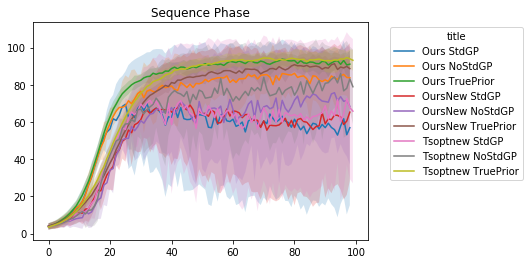

In [158]:
files = ["../result/gauss_final/ours/",
        "../result/gauss_final/oursnew/",
        "../result/gauss_final/tsoptnew/"]

labels = ['Ours', 'OursNew','Tsoptnew']

plot_test_seq(files, 
              seq_idx=2, 
              has_mode_list=[True, True,True], 
              label_list=labels,
              seqname='Phase')

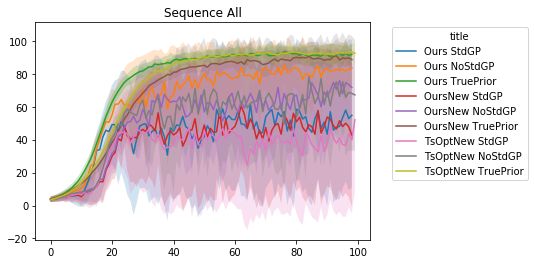

In [157]:
files = ["../result/gauss_final/ours/",
        "../result/gauss_final/oursnew/",
        '../result/gauss_final/tsoptnew/']

labels = ['Ours', 'OursNew','TsOptNew']

plot_test_seq(files, 
              seq_idx=3, 
              has_mode_list=[True, True,True], 
              label_list=labels,
              seqname='All')

# EXPLORE V0

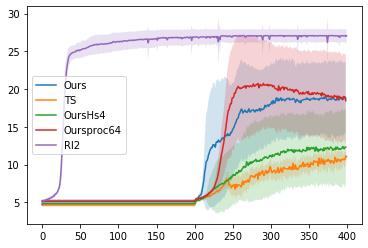

In [1192]:
files = ["../result/explorefinal/ours/", "../result/explorefinal/tsopt/", "../result/explorefinal/ourshs4/",
        "../result/explorefinal/oursproc64/","../result/explorefinal/rl2/"]

labels = ["Ours", "TS", "OursHs4", "Oursproc64", "Rl2"]

offset_list = [50000 // 250, 50000 // 250, 50000 // 250, 50000 // 250, 0]

r = plot_eval_offset(files, labels, offset_list, [True, False, False, False])

# MINIGOLF

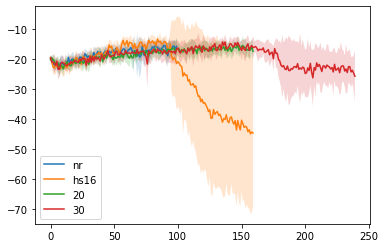

In [179]:
files = ["../result/minigolf/rl2snewrange/",
        "../result/minigolf/rl2hs16/",
        "../result/minigolf/rl220000/",
        "../result/minigolf/rl230000/"]

labels = ['nr', 'hs16', '20', '30']

r = plot_eval(files, labels)

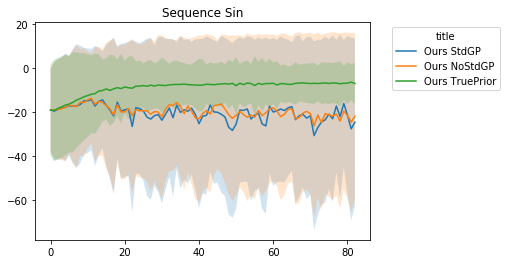

In [130]:
files = ["../result/minigolf/oursfinalnew/"]

labels = ['Ours']

plot_test_seq(files, 
              seq_idx=0, 
              has_mode_list=[True], 
              label_list=labels,
              seqname='Sin')

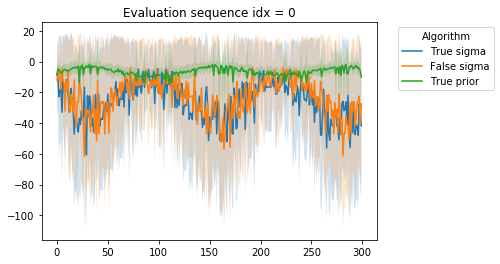

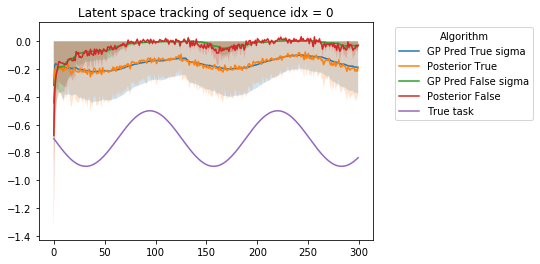

In [133]:
view_tracking("../result/minigolf/oursfinalnew/", prior_sequences)

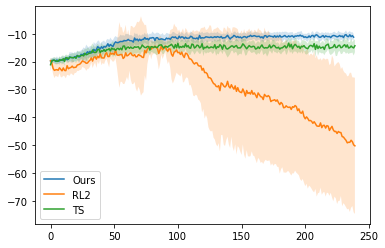

In [92]:
files = ["../result/golf_final/oursfinal/",
        "../result/golf_final/rl2final/",
        "../result/golf_final/tsoptfinal/"]

labels = ['Ours', 'RL2', 'TS']

r = plot_eval(files, labels)

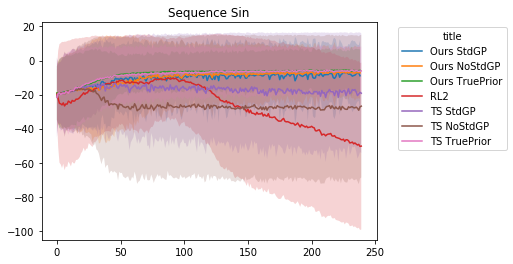

In [57]:
files = ["../result/golf_final/oursfinal/",
        "../result/golf_final/rl2final/",
        "../result/golf_final/tsoptfinal/",]

labels = ['Ours', 'RL2', 'TS']

plot_test_seq(files, 
              seq_idx=0, 
              has_mode_list=[True, False, True], 
              label_list=labels,
              seqname='Sin')

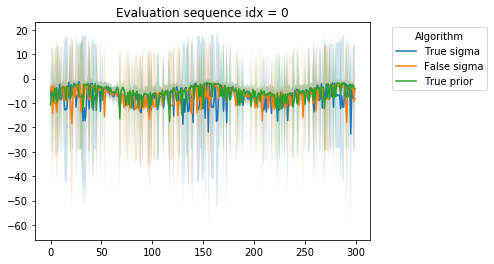

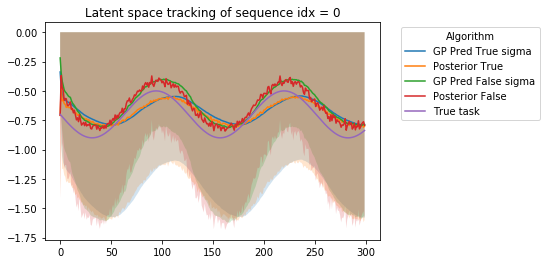

In [89]:
view_tracking("../result/golf_final/oursfinal/", prior_sequences)

In [132]:
import torch
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from gym import spaces

def get_sin_task_sequence(alpha, n_restarts, num_test_processes, std=0.00000001):
    kernel = C(1.0, (1e-8, 1e8)) * RBF(1, (1e-8, 1e8))

    gp_list = []
    for i in range(num_test_processes):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=False,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])

    f = 0.05
    offset = -0.7
    a = -0.2

    init_prior_test = [torch.tensor([[a * np.sin(0) + offset], [std]], dtype=torch.float32)
                       for _ in range(num_test_processes)]

    prior_seq = []
    for idx in range(300):
        friction = a * np.sin(f * idx) + offset
        prior_seq.append(torch.tensor([[friction], [std]], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test


def get_const_task_sequence(alpha, n_restarts, num_test_processes, std=0.00000001):
    kernel = C(1.0, (1e-8, 1e8)) * RBF(1, (1e-8, 1e8))

    gp_list = []
    for i in range(num_test_processes):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=False,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])

    friction = -0.7
    init_prior_test = [torch.tensor([[friction], [std]], dtype=torch.float32)
                       for _ in range(num_test_processes)]
    prior_seq = []
    for idx in range(300):
        prior_seq.append(torch.tensor([[friction], [std]], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test



def get_sequences(alpha, n_restarts, num_test_processes, std):
    # Retrieve task
    gp_list_const, prior_seq_const, init_prior_const = get_const_task_sequence(alpha, n_restarts, num_test_processes, std)
    gp_list_sin, prior_seq_sin, init_prior_sin = get_sin_task_sequence(alpha, n_restarts, num_test_processes, std)

    # Fill lists
    prior_sequences = [prior_seq_sin]
    gp_list_sequences = [gp_list_sin]
    init_prior = [init_prior_sin]

    return prior_sequences, gp_list_sequences, init_prior

prior_sequences, _, _ = get_sequences(0.1, 1, 1, 0.01)

In [70]:
def get_meta_test(f, algo, gp_list_sequences, sw_size, prior_sequences, init_prior_sequences,
                  num_eval_processes, task_generator, store_history):
    env_name="minigolf-v0"
    seed = 0
    log_dir = "."
    use_env_obs = True
    
    action_space = spaces.Box(low=1e-5,
                              high=10.,
                              shape=(1,))
    res_list = []
    if algo == "rl2":
        dirs_containing_res = os.listdir(f)
        model_list = []

        for d in dirs_containing_res:
            model_list.append(torch.load(f + d + "/rl2_actor_critic"))
        
        for model in model_list:
            agent = RL2(hidden_size=8,
                        use_elu=True,
                        clip_param=0.2,
                        ppo_epoch=4,
                        num_mini_batch=8,
                        value_loss_coef=0.5,
                        entropy_coef=0,
                        lr=0.0005,
                        eps=1e-6,
                        max_grad_norm=0.5,
                        action_space=action_space,
                        obs_shape=(3,),
                        use_obs_env=True,
                        num_processes=32,
                        gamma=0.99,
                        device="cpu",
                        num_steps=20,
                        action_dim=1,
                        use_gae=False,
                        gae_lambda=0.95,
                        use_proper_time_limits=False)
            agent.actor_critic = model
            res = agent.meta_test(prior_sequences, task_generator, num_eval_processes, env_name, seed, log_dir)
            res_list.append(res)
    if algo == "ours":
        
        model_list = []
        vi_list = []
        dirs_containing_res = os.listdir(f)

        for d in dirs_containing_res:
            model_list.append(torch.load(f + d + "/agent_ac"))
            vi_list.append(torch.load(f + d + "/agent_vi"))
            
        for model, vi in zip(model_list, vi_list):
            agent = OursAgent(action_space=action_space, device="cpu", gamma=1,
                              num_steps=20, num_processes=32,
                              clip_param=0.2, ppo_epoch=4,
                              num_mini_batch=8,
                              value_loss_coef=0.5,
                              entropy_coef=0,
                              lr=0.00005,
                              eps=1e-6, max_grad_norm=0.5,
                              use_linear_lr_decay=False,
                              use_gae=False,
                              gae_lambda=0.95,
                              use_proper_time_limits=False,
                              obs_shape=(3, ),
                              latent_dim=1,
                              recurrent_policy=False,
                              hidden_size=8,
                              use_elu=False,
                              variational_model=None,
                              vae_optim=None,
                              rescale_obs=False,
                              max_old=None,
                              min_old=None,
                              vae_min_seq=1,
                              vae_max_seq=20,
                              max_action=None,
                              min_action=None,
                              max_sigma=0.4,
                              use_decay_kld=True,
                              decay_kld_rate=1,
                              env_dim=1
                              )
            agent.actor_critic = model
            agent.vae = vi
            res = agent.meta_test_sequences(gp_list_sequences=gp_list_sequences,
                                                 sw_size=sw_size,
                                                 env_name=env_name,
                                                 seed=seed,
                                                 log_dir=log_dir,
                                                 prior_sequences=prior_sequences,
                                                 init_prior_sequences=init_prior_sequences,
                                                 use_env_obs=True,
                                                 num_eval_processes=1,
                                                 task_generator=task_generator,
                                                 store_history=store_history)
            res_list.append(res)
    return res_list

In [67]:
from task.mini_golf_task_generator import MiniGolfTaskGenerator
from learner.recurrent import RL2
import gym_sin
from learner.ours import OursAgent
task_generator = MiniGolfTaskGenerator(prior_std_min=0.0001,
                                       prior_std_max=0.4)

In [30]:
prior_sequences, _, _ = get_sequences(0.1, 1, 1, 0.00001)
r = get_meta_test("../result/minigolf/rl220000/", "rl2", None, 0, prior_sequences, None,
                  1, task_generator, None)
r = np.array(r)
# r = r.squeeze(1)
#plt.plot(np.mean(r, 0))
#np.mean(r)

In [81]:
prior_sequences, gp_list_sequences, init_prior = get_sequences(0.1, 1, 1, 0.001)
r_ours = get_meta_test("../result/minigolf/oursrobhs16/", "ours", gp_list_sequences, 10, prior_sequences, init_prior,
                  1, task_generator, True)
r_ours = np.array(r_ours)
# r = r.squeeze(2)

#plt.plot(np.mean(r[:, 0, :], 0))
#plt.plot(np.mean(r[:, 1, :], 0))
#plt.plot(np.mean(r[:, 2, :], 0))

#print(np.mean(r[:, 0, :]))
#print(np.mean(r[:, 1, :]))
#print(np.mean(r[:, 2, :]))

C:\Users\Riccardo\Anaconda3\envs\sequential-transfer-rl\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'inference.inference_network.InferenceNetwork' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


SEQ IDX 0
Using GP True sigma -7.426666666666667
Using GP False sigma -6.966666666666667
Using real prior -6.706666666666667
SEQ IDX 0
Using GP True sigma -10.006666666666666
Using GP False sigma -6.406666666666666
Using real prior -6.533333333333333
SEQ IDX 0
Using GP True sigma -7.526666666666666
Using GP False sigma -6.376666666666667
Using real prior -5.97
SEQ IDX 0
Using GP True sigma -5.413333333333333
Using GP False sigma -6.713333333333333
Using real prior -6.263333333333334
SEQ IDX 0
Using GP True sigma -7.156666666666666
Using GP False sigma -6.166666666666667
Using real prior -5.3566666666666665
SEQ IDX 0
Using GP True sigma -7.583333333333333
Using GP False sigma -6.503333333333333
Using real prior -5.18
SEQ IDX 0
Using GP True sigma -7.8
Using GP False sigma -8.23
Using real prior -5.5633333333333335
SEQ IDX 0
Using GP True sigma -6.803333333333334
Using GP False sigma -7.556666666666667
Using real prior -5.77


In [50]:
def view_seq(r_list, label_list, has_track_list, num_seq, prior_seqs):
    for seq in range(num_seq):
        # View rewards
        for r, label, has_track in zip(r_list, label_list, has_track_list):
            if not has_track:
                plt.plot(np.mean(r[:, seq, :], 0), label=label)
                print("Mean {} seq {}".format(label, np.mean(r[:, seq, :])))
            else:
                t = np.array([r[p, 0, seq] for p in range(r.shape[0])])
                plt.plot(np.mean(t, 0), label=label + " True sigma")
                print("Mean {} seq {}".format(label, np.mean(t)))
                
                t = np.array([r[p, 1, seq] for p in range(r.shape[0])])
                plt.plot(np.mean(t, 0), label=label + " False sigma")
                print("Mean {} seq {}".format(label, np.mean(t)))

                t = np.array([r[p, 2, seq] for p in range(r.shape[0])])
                plt.plot(np.mean(t, 0), label=label + " True prior")
                print("Mean {} seq {}".format(label, np.mean(t)))
                

        plt.title("Seq idx {}".format(seq))
        plt.legend()
        plt.show()

        # View tracking
        for r, label, has_track in zip(r_list, label_list, has_track_list):
            if has_track:
                t = np.array([r[p, 3, seq][:, 0, 0].tolist() for p in range(r.shape[0])])
                plt.plot(np.mean(t, 0), label=label + " Posterior true")
                
                t = np.array([r[p, 5, seq][:, 0, 0].tolist() for p in range(r.shape[0])])
                plt.plot(np.mean(t, 0), label=label + " Posterior false")
                
                t = np.array([r[p, 4, seq] for p in range(r.shape[0])])
                plt.plot(np.mean(t, 0), label=label + " Prediction true")
                
                t = np.array([r[p, 6, seq] for p in range(r.shape[0])])
                plt.plot(np.mean(t, 0), label=label + " Prediction false")
                
                num_t = len(prior_seqs[seq])
                true_task = [prior_seqs[seq][i][0].item() for i in range(num_t)]
                plt.plot(true_task, label="True task")
            
        plt.title("Seq idx {}".format(seq))
        plt.legend()
        plt.show()

Mean Ours seq -7.464583333333334
Mean Ours seq -6.865
Mean Ours seq -5.917916666666667


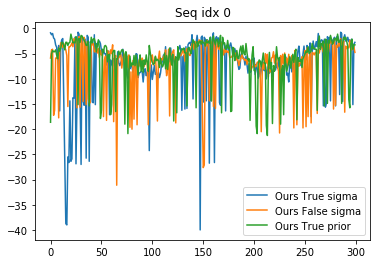

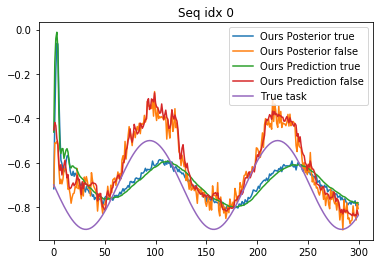

In [82]:
view_seq([r_ours], ["Ours"], [True], 1, prior_sequences)

# Navigation

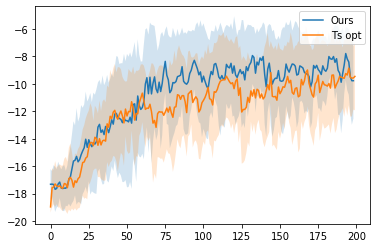

In [11]:
files = ["../result/navigationv0/ours/", "../result/navigationv0/tsopt/"]

labels = ["Ours", "Ts opt"]

r = plot_eval(files, labels)

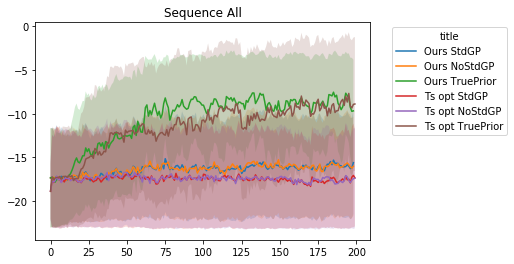

In [24]:
files = ["../result/navigationv0/ours/", "../result/navigationv0/tsopt/"]

labels = ["Ours", "Ts opt"]

plot_test_seq(files, 
              seq_idx=0, 
              has_mode_list=[True, True], 
              label_list=labels,
              seqname='All')

In [181]:
f = "../result/gauss_final/oursnew2/"
dirs_containing_res = os.listdir(f)
eval_file_list = []
for d in dirs_containing_res:
    eval_file_list.append(f + d + "/vae.pkl")
e = read_file_list(eval_file_list)
e = np.array(e)


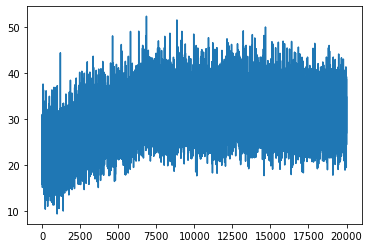

In [183]:
plt.plot(np.mean(e[:, 0, 5000:, 0], 0))

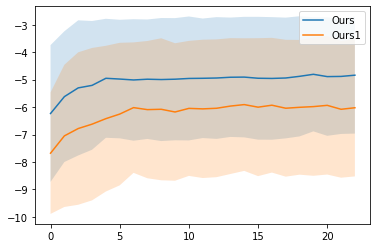

In [193]:
files = ["../result/navigationv0/oursnosignal/", "../result/navigationv0/oursnumsignal1/"]

labels = ['Ours', 'Ours1']

r = plot_eval(files, labels)

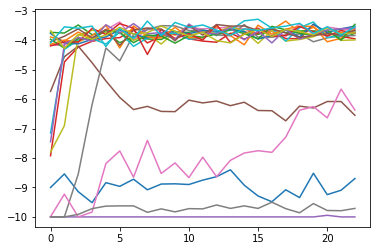

In [196]:
for i in range(20):
    plt.plot(r[0][i])

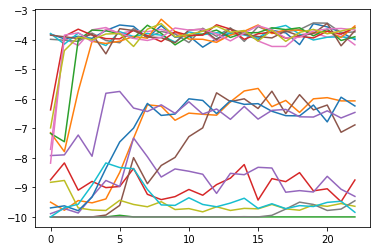

In [197]:
for i in range(20):
    plt.plot(r[1][i])

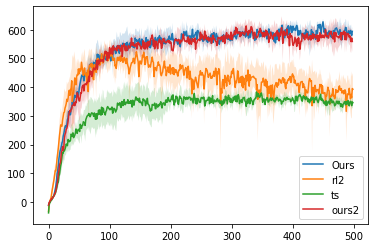

In [198]:
files = ["../result/ant/ours/", "../result/ant/rl2/",  "../result/ant/tsopt/", "../result/ant/oursinitvae/"]

labels = ['Ours', 'rl2', 'ts','ours2']

r = plot_eval(files, labels)

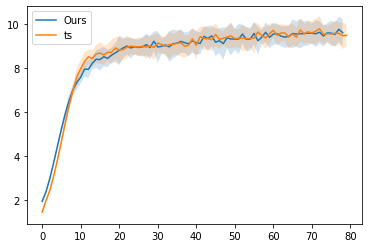

In [9]:
files = ["../result/scalegauss_final/ours/","../result/scalegauss_final/tsopt/"]

labels = ['Ours', 'ts']

r = plot_eval(files, labels)

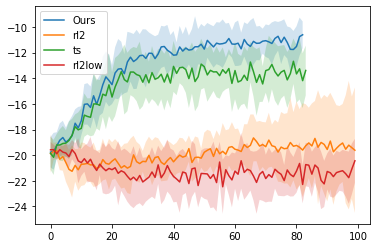

In [213]:
files = ["../result/golf_fixed_final/ours/", "../result/golf_fixed_final/rl2/",  "../result/golf_fixed_final/tsopt/","../result/golf_fixed_final/rl2low/"]

labels = ['Ours', 'rl2', 'ts', 'rl2low']

r = plot_eval(files, labels)

In [17]:
f = "../result/scalegauss_final/tsopt/"
dirs_containing_res = os.listdir(f)
eval_file_list = []
        
for d in dirs_containing_res:
    eval_file_list.append(f + d + "/vae.pkl")
e = read_file_list(eval_file_list)
e = np.array(e)


In [18]:
e.shape

(20, 1, 20000)

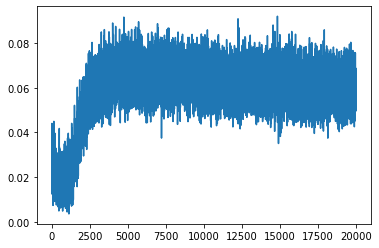

In [20]:
plt.plot(np.mean(e[:, 0, :], 0))

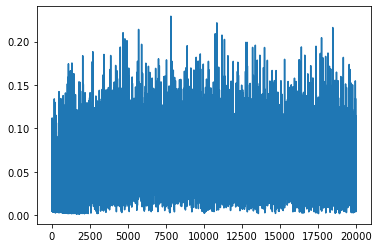

In [21]:
plt.plot(e[0, 0, :])

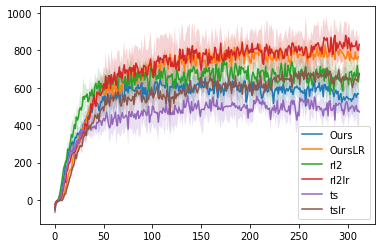

In [8]:
files = ["../result/newant/ours/",
         "../result/newant/ourssmalllr/",
         "../result/newant/rl2/",
         "../result/newant/rl2smalllr/",
         "../result/newant/tsopt/",
          "../result/newant/tsoptsmalllr/"
        ]

labels = ['Ours', 'OursLR', 'rl2', 'rl2lr', 'ts', 'tslr']

r = plot_eval(files, labels)

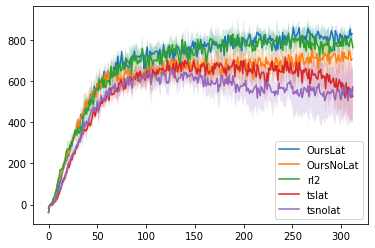

In [8]:
files = ["../result/ant2leg/ours2leglat/",
         "../result/ant2leg/ours2legnolat/",
         "../result/ant2leg/rl22leg/",
         "../result/ant2leg/tsopt2leglat/",
         "../result/ant2leg/tsopt2legnolat/"
        ]

labels = ['OursLat', 'OursNoLat', 'rl2', 'tslat', 'tsnolat']

r = plot_eval(files, labels)

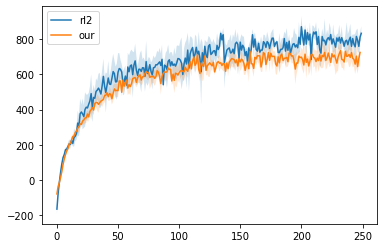

In [9]:
files = ["../result/antfocus/rl2focus/",
         "../result/antfocus/oursfocus/"
        ]

labels = ['rl2', 'our']

r = plot_eval(files, labels)

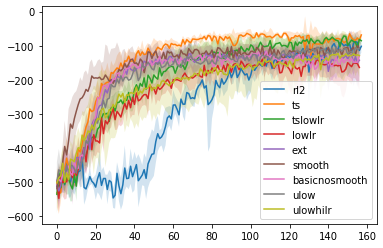

In [37]:
files = ["../result/cheetahvelv2all/rl2400/",
         "../result/cheetahvelv2all/tsoptfin/",
         "../result/cheetahvelv2all/tsoptfinlowlr/",
         "../result/cheetahvelv2all/oursextlowlr/",
         "../result/cheetahvelv2all/oursext/",
         "../result/cheetahvelv2all/oursextsmooth/",
         "../result/cheetahvelv2all/oursextnosmooth/",
         "../result/cheetahvelv2all/oursextulow/",
         "../result/cheetahvelv2all/oursextulowhilr/"
        ]

labels = ['rl2', 'ts', 'tslowlr','lowlr', 'ext', 'smooth', 'basicnosmooth', 'ulow', 'ulowhilr']

r = plot_eval(files, labels)

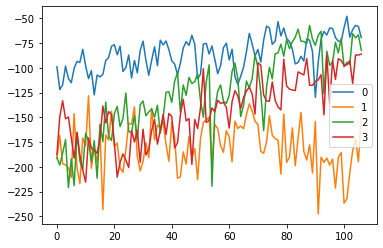

In [108]:
f = "../result/cheetahvelv2all/oursextulow/"
        
dirs_containing_res = os.listdir(f)
eval_file_list = []
        
for d in dirs_containing_res:
    eval_file_list.append(f + d + "/eval.pkl")
e = read_file_list(eval_file_list)
e = np.array(e)

e = e.squeeze(1)

for i in range(4):
    plt.plot(e[i, 50:], label="{}".format(i))
plt.legend()

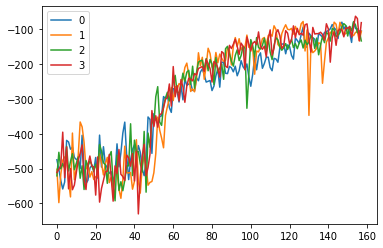

In [57]:
f = "../result/cheetahvelv2all/rl2400/"
        
dirs_containing_res = os.listdir(f)
eval_file_list = []
        
for d in dirs_containing_res:
    eval_file_list.append(f + d + "/eval.pkl")
e_o = read_file_list(eval_file_list)
e_o = np.array(e_o)

e_o = e_o.squeeze(1)

for i in range(4):
    plt.plot(e_o[i], label="{}".format(i))
plt.legend()

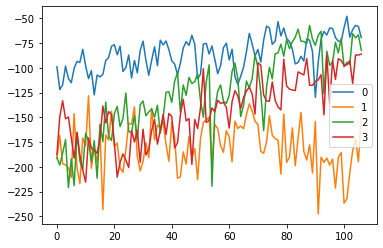

In [83]:
f = "../result/cheetahvelv2all/oursextulow/"
        
dirs_containing_res = os.listdir(f)
eval_file_list = []
        
for d in dirs_containing_res:
    eval_file_list.append(f + d + "/eval.pkl")
e_o = read_file_list(eval_file_list)
e_o = np.array(e_o)
e_o = e_o.squeeze(1)

for i in range(4):
    plt.plot(e_o[i, 50:], label="{}".format(i))
plt.legend()

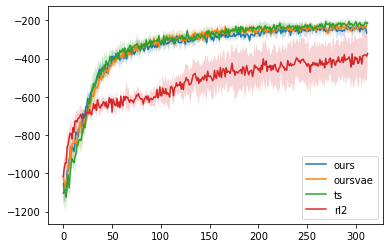

In [15]:
files = ["../result/antgoal/ours/",
         "../result/antgoal/oursvae/",
         "../result/antgoal/ts/",
         "../result/antgoal/rl2/"
        ]

labels = ['ours', 'oursvae', 'ts', 'rl2']

r = plot_eval(files, labels)

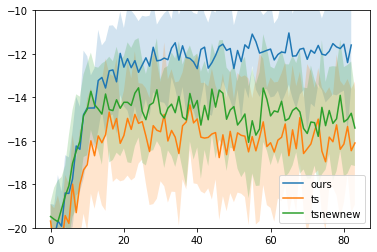

In [59]:
files = ["../result/oursnew/", "../result/tsnew/", "../result/tsnewnew/"]

labels = ['ours', 'ts', 'tsnewnew']
plt.ylim(-20, -10)
r = plot_eval(files, labels)

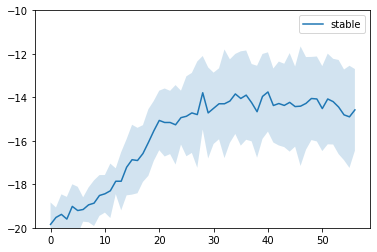

In [11]:
files = ["../result/rl2maystable/"]

labels = ['stable']
plt.ylim(-20, -10)
r = plot_eval(files, labels)

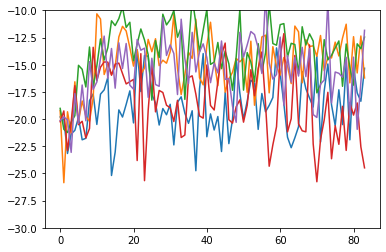

In [56]:
f = "../result/tsnew/"
        
dirs_containing_res = os.listdir(f)
eval_file_list = []
        
for d in dirs_containing_res:
    eval_file_list.append(f + d + "/eval.pkl")
e_o = read_file_list(eval_file_list)
e_o = np.array(e_o)

e_o = e_o.squeeze(1)

plt.ylim((-30,-10))
for i in range(5):
    plt.plot(e_o[i], label="{}".format(i))


FileNotFoundError: [WinError 3] Impossibile trovare il percorso specificato: '../result/antgoal/ours300/'

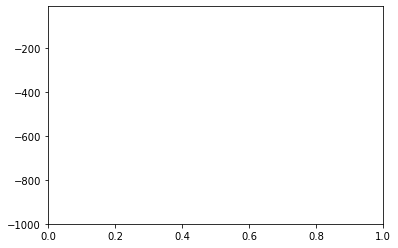

In [131]:
files = ["../result/antgoal/ours300/", "../result/antgoal/tsvae/", "../result/antgoal/ours1batch/"]

labels = ['ours300', "tsvae", "ours1batch"]
plt.ylim(-1000, -10)
r = plot_eval(files, labels)

FileNotFoundError: [WinError 3] Impossibile trovare il percorso specificato: '../result/antgoal/tsvae/'

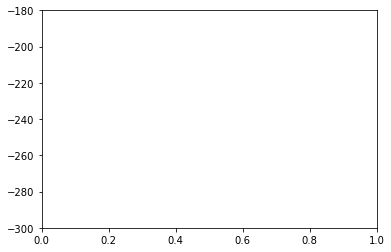

In [132]:
files = ["../result/antgoal/tsvae/", "../result/antgoal/ours1batch/"]

labels = ["tsvae", "ours1batch"]
plt.ylim(-300, -180)
r = plot_eval(files, labels)

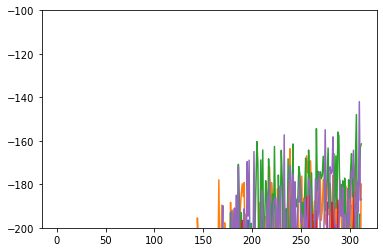

In [26]:
f = "../result/antgoal/tsvae/"
        
dirs_containing_res = os.listdir(f)
eval_file_list = []
        
for d in dirs_containing_res:
    eval_file_list.append(f + d + "/eval.pkl")
e_o = read_file_list(eval_file_list)
e_o = np.array(e_o)

e_o = e_o.squeeze(1)

plt.ylim((-200,-100))
for i in range(5):
    plt.plot(e_o[i], label="{}".format(i))


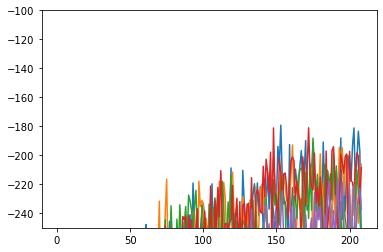

In [29]:
f = "../result/antgoal/ours300/"
        
dirs_containing_res = os.listdir(f)
eval_file_list = []
        
for d in dirs_containing_res:
    eval_file_list.append(f + d + "/eval.pkl")
e_o = read_file_list(eval_file_list)
e_o = np.array(e_o)

e_o = e_o.squeeze(1)

plt.ylim((-250,-100))
for i in range(5):
    plt.plot(e_o[i], label="{}".format(i))


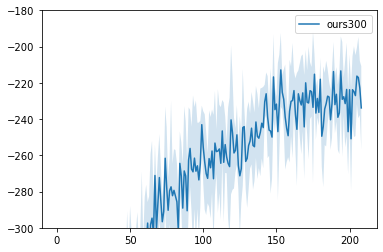

In [41]:
files = ["../result/antgoal/ours300/"]

labels = ["ours300"]
plt.ylim(-300, -180)
r = plot_eval(files, labels)

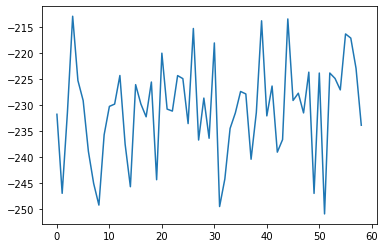

In [43]:
plt.plot(np.mean(r[0][:, 150:], 0))

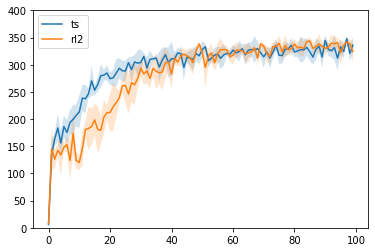

In [13]:
files = ["../result/cartpole/ts/", "../result/cartpole/rl2/"]

labels = ["ts", "rl2"]
plt.ylim(0, 400)
r = plot_eval(files, labels)

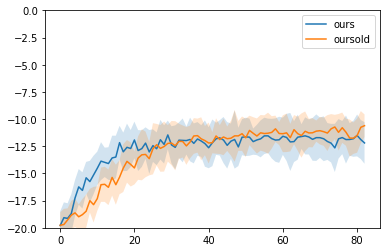

In [127]:
files = ["../result/ourssig3/", "../result/policies/golf/ours/"]

labels = ["ours", "oursold"]
plt.ylim(-20, 0)
r = plot_eval(files, labels)

In [5]:
def f_radius(theta, latent_dim):
    if latent_dim == 0:
        return np.cos(theta)
    else:
        return np.sin(theta)


def linear_theta(x):
    return x * 2 * np.pi / 20


def get_ant_goal_sequences(std):
    circuit = get_circuit_sequence(seq_len=20, std=std)
    const = get_ant_constant_sequence(seq_len=30, std=std)
    step = get_ant_step_sequence(seq_len=40, std=std)

    return [circuit, const, step]


def get_circuit_sequence(seq_len, std):
    latent_dim = 2
    prior_seq = []
    for idx in range(seq_len):
        p_mean = []
        p_var = []
        theta = linear_theta(idx)
        for dim in range(latent_dim):
            p_mean.append(f_radius(theta=theta, latent_dim=dim))
            p_var.append(std ** 2)

        p_mean = (3 - (-3)) / (1 - (-1)) * (np.array([p_mean]) - 1) + 3
        p_mean = p_mean.tolist()
        prior_seq.append(torch.tensor([p_mean, p_var], dtype=torch.float32))

    return prior_seq


def get_ant_constant_sequence(seq_len, std):
    latent_dim = 2
    theta_const = np.pi / 4
    prior_seq = []
    for idx in range(seq_len):
        p_mean = []
        p_var = []
        for dim in range(latent_dim):
            p_mean.append(f_radius(theta=theta_const, latent_dim=dim))
            p_var.append(std ** 2)

        p_mean = (3 - (-3)) / (1 - (-1)) * (np.array([p_mean]) - 1) + 3
        p_mean = p_mean.tolist()
        prior_seq.append(torch.tensor([p_mean, p_var], dtype=torch.float32))

    return prior_seq


def get_ant_step_sequence(seq_len, std):
    latent_dim = 2
    prior_seq = []
    for idx in range(seq_len):
        p_mean = []
        p_var = []
        theta = np.pi / 4 if idx <= 20 else -np.pi / 4
        for dim in range(latent_dim):
            p_mean.append(f_radius(theta=theta, latent_dim=dim))
            p_var.append(std ** 2)

        p_mean = (3 - (-3)) / (1 - (-1)) * (np.array(p_mean) - 1) + 3
        p_mean = p_mean.tolist()
        print(p_mean)
        print(p_var)
        prior_seq.append(torch.tensor([p_mean, p_var], dtype=torch.float32))

    return prior_seq

get_ant_step_sequence(10, 0.001)

[2.121320343559643, 2.121320343559643]
[1e-06, 1e-06]
[2.121320343559643, 2.121320343559643]
[1e-06, 1e-06]
[2.121320343559643, 2.121320343559643]
[1e-06, 1e-06]
[2.121320343559643, 2.121320343559643]
[1e-06, 1e-06]
[2.121320343559643, 2.121320343559643]
[1e-06, 1e-06]
[2.121320343559643, 2.121320343559643]
[1e-06, 1e-06]
[2.121320343559643, 2.121320343559643]
[1e-06, 1e-06]
[2.121320343559643, 2.121320343559643]
[1e-06, 1e-06]
[2.121320343559643, 2.121320343559643]
[1e-06, 1e-06]
[2.121320343559643, 2.121320343559643]
[1e-06, 1e-06]


[tensor([[2.1213e+00, 2.1213e+00],
         [1.0000e-06, 1.0000e-06]]), tensor([[2.1213e+00, 2.1213e+00],
         [1.0000e-06, 1.0000e-06]]), tensor([[2.1213e+00, 2.1213e+00],
         [1.0000e-06, 1.0000e-06]]), tensor([[2.1213e+00, 2.1213e+00],
         [1.0000e-06, 1.0000e-06]]), tensor([[2.1213e+00, 2.1213e+00],
         [1.0000e-06, 1.0000e-06]]), tensor([[2.1213e+00, 2.1213e+00],
         [1.0000e-06, 1.0000e-06]]), tensor([[2.1213e+00, 2.1213e+00],
         [1.0000e-06, 1.0000e-06]]), tensor([[2.1213e+00, 2.1213e+00],
         [1.0000e-06, 1.0000e-06]]), tensor([[2.1213e+00, 2.1213e+00],
         [1.0000e-06, 1.0000e-06]]), tensor([[2.1213e+00, 2.1213e+00],
         [1.0000e-06, 1.0000e-06]])]